What is this notebook for?

I want to build a web service that:
- Gets the URL in the request
- Loads the image from this URL
- Uses TensorFlow Lite to apply the model to the image and get the predictions
- Responds with the results

Steps:
- Testing the model
- Converting the model to TensorFlow Lite format
- Loading the model and getting input and output indices
- Inference part
- Removing TensorFlow dependency
- Excluding TensorFlow dependency completely

- Create and test the lambda function

In [1]:
%autosave 0

Autosave disabled


## Step 0: Testing the model

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import load_img

2023-12-18 12:12:28.471903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 12:12:28.674923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 12:12:28.675070: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

--2023-12-18 12:12:31--  https://cdn.pixabay.com/photo/2021/01/13/14/51/airbus-a400m-atlas-5914332_960_720.jpg
Auflösen des Hostnamens cdn.pixabay.com (cdn.pixabay.com) … 172.64.147.160, 104.18.40.96, 2606:4700:4400::6812:2860, ...
Verbindungsaufbau zu cdn.pixabay.com (cdn.pixabay.com)|172.64.147.160|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 91758 (90K) [binary/octet-stream]
Wird in ‘airbus.jpg’ gespeichert.

airbus.jpg          100%[===================>]  89,61K  --.-KB/s    in 0,01s   

2023-12-18 12:12:31 (6,56 MB/s) - ‘airbus.jpg’ gespeichert [91758/91758]



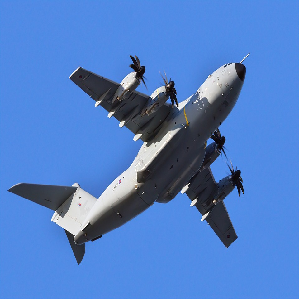

In [6]:
model = keras.models.load_model("./../Model/final_0.725.h5")
!wget 'https://cdn.pixabay.com/photo/2021/01/13/14/51/airbus-a400m-atlas-5914332_960_720.jpg' -O airbus.jpg

img = load_img('./airbus.jpg', target_size=(299,299))
img

In [51]:
# Preprocessing the image
x = np.array(img)
# Turning this image into a batch of one image
X = np.array([x])

classes = ['A400M', 'C130', 'Su57', 'Tu160']

pred = model.predict(X)
predicted_class_index = np.argmax(pred)
predicted_class_name = classes[predicted_class_index]
print(predicted_class_name)

dict(zip(classes, pred[0]))

1/1 [==============================] - 0s 16ms/step
A400M


{'A400M': 1.0, 'C130': 0.0, 'Su57': 0.0, 'Tu160': 0.0}

## Step 1: Converting the model to TensorFlow Lite format

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

# Saving the model in tflite format
with open('./../Model/final-model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmejluwzg/assets


INFO:tensorflow:Assets written to: /tmp/tmpmejluwzg/assets
2023-12-18 12:25:43.955623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-18 12:25:43.955644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-18 12:25:43.956242: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmejluwzg
2023-12-18 12:25:43.957692: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-18 12:25:43.957705: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmejluwzg
2023-12-18 12:25:43.961215: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-18 12:25:43.962424: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-18 12:25:44.119823: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

## Step 2: Loading the model and getting input and output indices

In [11]:
import tensorflow.lite as tflite 

interpreter = tflite.Interpreter(model_path="./../Model/final-model.tflite")

# Loading weights from model to memory
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [16]:
# Figuring out the input index
interpreter.get_input_details()

[{'name': 'serving_default_input_1:0',
  'index': 0,
  'shape': array([  1, 299, 299,   3], dtype=int32),
  'shape_signature': array([ -1, 299, 299,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [15]:
input_index = interpreter.get_input_details()[0]['index']

In [17]:
# Figuring out the output index
output_index = interpreter.get_output_details()[0]['index']
output_index

24

## Step 3: Inference part

In [34]:
#from keras.applications.xception import preprocess_input
#X = preprocess_input(X)

In [58]:
img = load_img('./airbus.jpg', target_size=(299,299))
# Preprocessing the image
x = np.array(img)
x = np.float32(x) / 255.
# Turning this image into a batch of one image
X = np.array([x])

In [61]:
# Initializing the input of the interpreter with the image X
interpreter.set_tensor(input_index, X)

# Invoking the computations in the neural network
interpreter.invoke()

In [62]:
# Results are in the output_index. so fetching the results...
preds = interpreter.get_tensor(output_index)
preds

array([[9.9999952e-01, 6.3226679e-10, 5.0820319e-07, 1.7749541e-10]],
      dtype=float32)

In [63]:
classes = ['A400M', 'C130', 'Su57', 'Tu160']

predicted_class_index = np.argmax(preds)
predicted_class_name = classes[predicted_class_index]
print(predicted_class_name)

dict(zip(classes, preds[0]))

A400M


{'A400M': 0.9999995,
 'C130': 6.322668e-10,
 'Su57': 5.082032e-07,
 'Tu160': 1.7749541e-10}

## Step 4: Removing TensorFlow dependency
I only want to use TensorFlow Lite, so I need to exclude the dependency while using the function load_image which lives in Keras, because Keras is not available in TensorFlow Lite.

In [ ]:
# Reading the image
img = load_img('./airbus.jpg', target_size=(299,299))

# Preprocessing the image
x = np.array(img)
x = np.float32(x) / 255.
# Turning this image into a batch of one image
X = np.array([x])


Let's see how to get rid of this dependency...

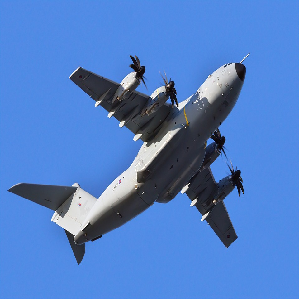

In [64]:
from PIL import Image

with Image.open('./airbus.jpg') as img:
    img = img.resize((299,299), Image.NEAREST)

img

In [67]:
def preprocess_input(x):
    #x /= 127.5
    #x -= 1.
    return x/255.

In [68]:
# Preprocessing the image
x = np.array(img, dtype='float32')

# Turning this image into a batch of one image
X = np.array([x])
X = preprocess_input(X)

# Initializing the input of the interpreter with the image X
interpreter.set_tensor(input_index, X)

# Invoking the computations in the neural network
interpreter.invoke()

# Results are in the output_index. so fetching the results...
preds = interpreter.get_tensor(output_index)
#preds

classes = ['A400M', 'C130', 'Su57', 'Tu160']

predicted_class_index = np.argmax(preds)
predicted_class_name = classes[predicted_class_index]
print(predicted_class_name)

dict(zip(classes, preds[0]))

A400M


{'A400M': 0.9999995,
 'C130': 6.322668e-10,
 'Su57': 5.082032e-07,
 'Tu160': 1.7749541e-10}

## Step 5: Excluding TensorFlow dependency completely

In [69]:
!pip install tflite-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 182.1 kB/s eta 0:00:0000:0100:01


In [75]:
from PIL import Image
import tflite_runtime.interpreter as tflite

def preprocess_input(x):
    return x/255.

In [76]:
interpreter = tflite.Interpreter(model_path='./../Model/final-model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

url = 'https://cdn.pixabay.com/photo/2021/01/13/14/51/airbus-a400m-atlas-5914332_960_720.jpg'
!wget {url} -O airbus.jpg

with Image.open('./airbus.jpg') as img:
    img = img.resize((299,299), Image.NEAREST)

# Preprocessing the image
x = np.array(img, dtype='float32')

# Turning this image into a batch of one image
X = np.array([x])
X = preprocess_input(X)

# Initializing the input of the interpreter with the image X
interpreter.set_tensor(input_index, X)

# Invoking the computations in the neural network
interpreter.invoke()

# Results are in the output_index. so fetching the results...
preds = interpreter.get_tensor(output_index)
#preds

classes = ['A400M', 'C130', 'Su57', 'Tu160']

predicted_class_index = np.argmax(preds)
predicted_class_name = classes[predicted_class_index]
print(predicted_class_name)

dict(zip(classes, preds[0]))

--2023-12-18 14:11:47--  https://cdn.pixabay.com/photo/2021/01/13/14/51/airbus-a400m-atlas-5914332_960_720.jpg
Auflösen des Hostnamens cdn.pixabay.com (cdn.pixabay.com) … 104.18.40.96, 172.64.147.160, 2606:4700:4400::6812:2860, ...
Verbindungsaufbau zu cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 91758 (90K) [binary/octet-stream]
Wird in ‘airbus.jpg’ gespeichert.

airbus.jpg          100%[===================>]  89,61K  --.-KB/s    in 0,01s   

2023-12-18 14:11:47 (7,56 MB/s) - ‘airbus.jpg’ gespeichert [91758/91758]

A400M


{'A400M': 0.9999995,
 'C130': 6.322644e-10,
 'Su57': 5.0820125e-07,
 'Tu160': 1.7749507e-10}

## Step 6: Create and test the lambda function

see Deployment folder.